<a href="https://colab.research.google.com/github/AUT-Student/CN-Project/blob/main/CN_Project_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Complex Network
<br>
<b>Description:</b> Final Project | Question 1
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import Tensor
from torch.nn import Linear, ReLU
import torch.nn.functional as F

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric
!pip install torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 1.1 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=007fb786dbad620b49f9c21cbeb5547124da28fbc12caa0cc5a6b0323623f14a
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 51.3 MB/s eta 0:00:00


In [ ]:
import torch_geometric

# Dataset

## Load

In [ ]:
from torch_geometric.datasets.planetoid import Planetoid

In [ ]:
planetoid = Planetoid("/content/planetoid", name="PubMed")

Processing...
Done!


In [ ]:
dataset = planetoid[0]

## Overview

In [ ]:
dataset

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [ ]:
set(dataset["y"].numpy())

{0, 1, 2}

In [ ]:
dataset.num_features

500

In [ ]:
dataset.num_edge_features

0

In [ ]:
(sum(dataset.train_mask), sum(dataset.val_mask), sum(dataset.test_mask))

(tensor(60), tensor(500), tensor(1000))

# Train and Test

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train(model):
  model.train()

  early_stopper = EarlyStopper(patience=3, min_delta=0.01)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(2000):
    pred = model(dataset.x, dataset.edge_index)
    train_loss = F.cross_entropy(pred[dataset.train_mask],
                                  dataset.y[dataset.train_mask])
    
    validation_loss = F.cross_entropy(pred[dataset.val_mask],
                                      dataset.y[dataset.val_mask])

    # Backpropagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if early_stopper.early_stop(validation_loss):             
        break

In [ ]:
def complete_test(model):
  model.eval()
  with torch.no_grad():
    pred = model(dataset.x, dataset.edge_index).argmax(dim=-1)

  accs = []
  for mask in [dataset.train_mask, dataset.val_mask, dataset.test_mask]:
      accs.append(int((pred[mask] == dataset.y[mask]).sum()) / int(mask.sum()))

  print(f"Train Accuracy = {accs[0]}")
  print(f"Valid Accuracy = {accs[1]}")
  print(f"Test  Accuracy = {accs[2]}")

In [ ]:
def test(model):
  model.eval()
  with torch.no_grad():
    pred = model(dataset.x, dataset.edge_index).argmax(dim=-1)


  return int((pred[dataset.test_mask] == dataset.y[dataset.test_mask]).sum()) / int(dataset.test_mask.sum())

# Models

## GCN

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, dimentions, number_gcn, number_fc):
        super().__init__()
        assert(len(dimentions) == number_gcn+number_fc+1)
        self.number_gcn = number_gcn
        self.number_fc = number_fc
        self.layers_gcn = []
        self.layers_fc = []

        for in_dim, out_dim in zip(dimentions[:number_gcn],
                                   dimentions[1:number_gcn+1]):
          
          self.layers_gcn.append(GCNConv(in_dim, out_dim))
          
        self.layers_gcn = torch.nn.ModuleList(self.layers_gcn)
        
        for in_dim, out_dim in zip(dimentions[number_gcn:],
                                   dimentions[number_gcn+1:]):
          
          self.layers_fc.append(Linear(in_dim, out_dim))
        
        self.layers_fc = torch.nn.ModuleList(self.layers_fc)
        

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        for i in range(self.number_gcn):
          x = self.layers_gcn[i](x, edge_index).relu()

        for i in range(self.number_fc):
          x = self.layers_fc[i](x).sigmoid()

        return x

## GAT

In [ ]:
# Source: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels[0], heads,
                             concat=False, dropout=0.3)
        self.conv2 = GATConv(hidden_channels[0], hidden_channels[1], heads=1,
                             concat=False, dropout=0.3)
        self.conv3 = GATConv(hidden_channels[1], out_channels, heads=1,
                             concat=False, dropout=0.3)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        return x

## GAT Dynamic Weight

In [ ]:
# Source: https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/nn/conv/gat_conv.py

from typing import Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import NoneType  # noqa
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
)

import torch_sparse

from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros

class GATConvDynamicWeights(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.

    If the graph has multi-dimensional edge features :math:`\mathbf{e}_{i,j}`,
    the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j
        \, \Vert \, \mathbf{\Theta}_{e} \mathbf{e}_{i,j}]\right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k
        \, \Vert \, \mathbf{\Theta}_{e} \mathbf{e}_{i,k}]\right)\right)}.

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): <REMOVED by me> If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        edge_dim (int, optional): Edge feature dimensionality (in case
            there are any). (default: :obj:`None`)
        fill_value (float or Tensor or str, optional): The way to generate
            edge features of self-loops (in case :obj:`edge_dim != None`).
            If given as :obj:`float` or :class:`torch.Tensor`, edge features of
            self-loops will be directly given by :obj:`fill_value`.
            If given as :obj:`str`, edge features of self-loops are computed by
            aggregating all features of edges that point to the specific node,
            according to a reduce operation. (:obj:`"add"`, :obj:`"mean"`,
            :obj:`"min"`, :obj:`"max"`, :obj:`"mul"`). (default: :obj:`"mean"`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V_s}|, F_{s}), (|\mathcal{V_t}|, F_{t}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`,
          edge features :math:`(|\mathcal{E}|, D)` *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, H * F_{out})` or
          :math:`((|\mathcal{V}_t|, H * F_{out})` if bipartite.
          If :obj:`return_attention_weights=True`, then
          :math:`((|\mathcal{V}|, H * F_{out}),
          ((2, |\mathcal{E}|), (|\mathcal{E}|, H)))`
          or :math:`((|\mathcal{V_t}|, H * F_{out}), ((2, |\mathcal{E}|),
          (|\mathcal{E}|, H)))` if bipartite
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        # Changed Code:
        concat = False
        self.concat = concat
        
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        if isinstance(in_channels, int):
            self.lin_src = Linear(in_channels, heads * out_channels,
                                  bias=False, weight_initializer='glorot')
            self.lin_dst = self.lin_src
        else:
            self.lin_src = Linear(in_channels[0], heads * out_channels, False,
                                  weight_initializer='glorot')
            self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
                                  weight_initializer='glorot')

        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))

        # Changed Code:
        self.learnable_average_layer = torch.nn.Conv1d(in_channels=heads,
                                                       out_channels=1,
                                                       kernel_size=1)


        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
            self.att_edge = Parameter(torch.Tensor(1, heads, out_channels))
        else:
            self.lin_edge = None
            self.register_parameter('att_edge', None)

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        # super().reset_parameters()
        self.lin_src.reset_parameters()
        self.lin_dst.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att_src)
        glorot(self.att_dst)
        glorot(self.att_edge)
        zeros(self.bias)

        # Changed Code:
        # self.learnable_average_layer.reset_parameters()

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None,
                return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        # NOTE: attention weights will be returned whenever
        # `return_attention_weights` is set to a value, regardless of its
        # actual value (might be `True` or `False`). This is a current somewhat
        # hacky workaround to allow for TorchScript support via the
        # `torch.jit._overload` decorator, as we can only change the output
        # arguments conditioned on type (`None` or `bool`), not based on its
        # actual value.

        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = x_dst = self.lin_src(x).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        # Next, we compute node-level attention coefficients, both for source
        # and target nodes (if present):
        alpha_src = (x_src * self.att_src).sum(dim=-1)
        alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
        alpha = (alpha_src, alpha_dst)

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = torch_sparse.set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # edge_updater_type: (alpha: OptPairTensor, edge_attr: OptTensor)
        alpha = self.edge_updater(edge_index, alpha=alpha, edge_attr=edge_attr)

        # propagate_type: (x: OptPairTensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)

        # if self.concat:
        #     out = out.view(-1, self.heads * self.out_channels)
        # else:
        #     out = out.mean(dim=1)

        # Changed Code:
        # Source: https://stackoverflow.com/a/58574603/8961642
        out = self.learnable_average_layer(out)
        out = out.squeeze()
            
        if self.bias is not None:
            out = out + self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def edge_update(self, alpha_j: Tensor, alpha_i: OptTensor,
                    edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        # Given edge-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        if edge_attr is not None and self.lin_edge is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge

        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return alpha.unsqueeze(-1) * x_j

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [ ]:
class GATDynamicWeights(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConvDynamicWeights(in_channels, hidden_channels, heads,
                             dropout=0.3)

        self.conv2 = GATConvDynamicWeights(hidden_channels, out_channels, heads=1,
                             dropout=0.3)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        return x

## GAT V2 Message Operation

\begin{equation}
\mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
\sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j}
\end{equation}

\begin{equation}
\alpha_{i,j} =
        \frac{
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_k]
        \right)\right)}.
\end{equation}

\begin{equation}
\alpha_{i,j} =
        \frac{
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_j \, \Vert \, \mathbf{e}_{i,j}]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_k \, \Vert \, \mathbf{e}_{i,k}]
        \right)\right)}
\end{equation}

In [ ]:
# Source: https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/nn/conv/gatv2_conv.py

from typing import Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import (
    Adj,
    OptTensor,
    PairTensor,
    SparseTensor,
)
import torch_sparse
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

class GATv2ConvMessageOperation(MessagePassing):
    r"""The GATv2 operator from the `"How Attentive are Graph Attention
    Networks?" <https://arxiv.org/abs/2105.14491>`_ paper, which fixes the
    static attention problem of the standard
    :class:`~torch_geometric.conv.GATConv` layer.
    Since the linear layers in the standard GAT are applied right after each
    other, the ranking of attended nodes is unconditioned on the query node.
    In contrast, in :class:`GATv2`, every node can attend to any other node.
    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},
    where the attention coefficients :math:`\alpha_{i,j}` are computed as
    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_k]
        \right)\right)}.
    If the graph has multi-dimensional edge features :math:`\mathbf{e}_{i,j}`,
    the attention coefficients :math:`\alpha_{i,j}` are computed as
    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_j \, \Vert \, \mathbf{e}_{i,j}]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathbf{a}^{\top}\mathrm{LeakyReLU}\left(\mathbf{\Theta}
        [\mathbf{x}_i \, \Vert \, \mathbf{x}_k \, \Vert \, \mathbf{e}_{i,k}]
        \right)\right)}.
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        edge_dim (int, optional): Edge feature dimensionality (in case
            there are any). (default: :obj:`None`)
        fill_value (float or Tensor or str, optional): The way to generate
            edge features of self-loops (in case :obj:`edge_dim != None`).
            If given as :obj:`float` or :class:`torch.Tensor`, edge features of
            self-loops will be directly given by :obj:`fill_value`.
            If given as :obj:`str`, edge features of self-loops are computed by
            aggregating all features of edges that point to the specific node,
            according to a reduce operation. (:obj:`"add"`, :obj:`"mean"`,
            :obj:`"min"`, :obj:`"max"`, :obj:`"mul"`). (default: :obj:`"mean"`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        share_weights (bool, optional): If set to :obj:`True`, the same matrix
            will be applied to the source and the target node of every edge.
            (default: :obj:`False`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V_s}|, F_{s}), (|\mathcal{V_t}|, F_{t}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`,
          edge features :math:`(|\mathcal{E}|, D)` *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, H * F_{out})` or
          :math:`((|\mathcal{V}_t|, H * F_{out})` if bipartite.
          If :obj:`return_attention_weights=True`, then
          :math:`((|\mathcal{V}|, H * F_{out}),
          ((2, |\mathcal{E}|), (|\mathcal{E}|, H)))`
          or :math:`((|\mathcal{V_t}|, H * F_{out}), ((2, |\mathcal{E}|),
          (|\mathcal{E}|, H)))` if bipartite
    """
    _alpha: OptTensor

    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        message_operation,
        heads: int = 1,
        concat: bool = True,
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        share_weights: bool = False,
        **kwargs,
    ):
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.message_operation = message_operation
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value
        self.share_weights = share_weights

        if isinstance(in_channels, int):
            self.lin_l = Linear(in_channels, heads * out_channels, bias=bias,
                                weight_initializer='glorot')
            if share_weights:
                self.lin_r = self.lin_l
            else:
                self.lin_r = Linear(in_channels, heads * out_channels,
                                    bias=bias, weight_initializer='glorot')
        else:
            self.lin_l = Linear(in_channels[0], heads * out_channels,
                                bias=bias, weight_initializer='glorot')
            if share_weights:
                self.lin_r = self.lin_l
            else:
                self.lin_r = Linear(in_channels[1], heads * out_channels,
                                    bias=bias, weight_initializer='glorot')

        self.att = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
        else:
            self.lin_edge = None

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att)
        zeros(self.bias)

    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None,
                return_attention_weights: bool = None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels

        x_l: OptTensor = None
        x_r: OptTensor = None
        if isinstance(x, Tensor):
            assert x.dim() == 2
            x_l = self.lin_l(x).view(-1, H, C)
            if self.share_weights:
                x_r = x_l
            else:
                x_r = self.lin_r(x).view(-1, H, C)
        else:
            x_l, x_r = x[0], x[1]
            assert x[0].dim() == 2
            x_l = self.lin_l(x_l).view(-1, H, C)
            if x_r is not None:
                x_r = self.lin_r(x_r).view(-1, H, C)

        assert x_l is not None
        assert x_r is not None

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x_l.size(0)
                if x_r is not None:
                    num_nodes = min(num_nodes, x_r.size(0))
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = torch_sparse.set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # propagate_type: (x: PairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=(x_l, x_r), edge_attr=edge_attr,
                             size=None)

        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out = out + self.bias

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, x_i: Tensor, edge_attr: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        
        # Changed Code:
        # x = x_i + x_j
        x = self.message_operation(x_i, x_j)

        if edge_attr is not None:
            # Changed Code:
            raise NotImplementedError
            # if edge_attr.dim() == 1:
            #     edge_attr = edge_attr.view(-1, 1)
            # assert self.lin_edge is not None
            # edge_attr = self.lin_edge(edge_attr)
            # edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            # x = x + edge_attr

        x = F.leaky_relu(x, self.negative_slope)
        alpha = (x * self.att).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [ ]:
class GATv2MessageOperation(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, message_operation):
        super().__init__()
        self.conv1 = GATv2ConvMessageOperation(in_channels, hidden_channels,
                                      message_operation=message_operation,
                                      heads=heads, dropout=0.3)
        
        self.conv2 = GATv2ConvMessageOperation(hidden_channels * heads, out_channels,
                                      message_operation=message_operation,
                                      heads=1, dropout=0.3)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Results

## GCN

In [ ]:
NUMBER_RUNS = 4
for config in [
  ([500, 16, 8, 3], 2, 1),
  ([500, 32, 16, 3], 2, 1),
  ([500, 64, 32, 3], 2, 1),
  ([500, 256, 64, 3], 2, 1),        
  ([500, 1024, 1024, 3], 2, 1),
]:
  print(f"Config: {config[0]}")
  test_acc_sum = 0 
  for _ in range(NUMBER_RUNS):
    model = GCN(*config)
    train(model)
    test_acc_sum += test(model)
  test_acc = test_acc_sum / NUMBER_RUNS
  print(f"Test Accuracy: {round(test_acc*100, 2)}")
  print("====")

Config: [500, 16, 8, 3]
Test Accuracy: 75.8
====
Config: [500, 32, 16, 3]
Test Accuracy: 74.75
====
Config: [500, 64, 32, 3]
Test Accuracy: 75.05
====
Config: [500, 256, 64, 3]
Test Accuracy: 75.02
====
Config: [500, 1024, 1024, 3]
Test Accuracy: 75.2
====


In [ ]:
NUMBER_RUNS = 4
for config in [
  ([500, 16, 3], 1, 1),
  ([500, 16, 8, 3], 2, 1),
  ([500, 32, 16, 8, 3], 3, 1),
  ([500, 16, 8, 3], 1, 2),        
  ([500, 32, 16, 8, 3], 2, 2),
  ([500, 64, 32, 16, 8, 3], 3, 2),
  ([500, 32, 16, 8, 3], 1, 3),        
  ([500, 64, 32, 16, 8, 3], 2, 3),
  ([500, 128, 64, 32, 16, 8, 3], 3, 3)
]:
  print(f"Config: {config[0]}")
  test_acc_sum = 0 
  for _ in range(NUMBER_RUNS):
    model = GCN(*config)
    train(model)
    test_acc_sum += test(model)
  test_acc = test_acc_sum / NUMBER_RUNS
  print(f"Test Accuracy: {round(test_acc*100, 2)}")
  print("====")

Config: [500, 16, 3]
Test Accuracy: 70.0
====
Config: [500, 16, 8, 3]
Test Accuracy: 72.62
====
Config: [500, 32, 16, 8, 3]
Test Accuracy: 75.95
====
Config: [500, 16, 8, 3]
Test Accuracy: 49.5
====
Config: [500, 32, 16, 8, 3]
Test Accuracy: 53.5
====
Config: [500, 64, 32, 16, 8, 3]
Test Accuracy: 71.35
====
Config: [500, 32, 16, 8, 3]
Test Accuracy: 41.42
====
Config: [500, 64, 32, 16, 8, 3]
Test Accuracy: 57.3
====
Config: [500, 128, 64, 32, 16, 8, 3]
Test Accuracy: 65.72
====


## GAT

In [ ]:
NUMBER_RUNS = 4
test_accs = []
for heads in range(1, 11):
  print(f"heads = {heads}", end="")
  test_acc_sum = 0
  for _ in range(NUMBER_RUNS):
    model = GAT(500, [64, 16], 3, heads)
    train(model)
    test_acc_sum += test(model)
  test_acc = test_acc_sum / NUMBER_RUNS
  print(f"test accuracy = {test_acc}")
  test_accs.append(test_acc)

heads = 1test accuracy = 0.73225
heads = 2test accuracy = 0.7235
heads = 3test accuracy = 0.742
heads = 4test accuracy = 0.74
heads = 5test accuracy = 0.736
heads = 6test accuracy = 0.7374999999999999
heads = 7test accuracy = 0.73875
heads = 8test accuracy = 0.72575
heads = 9test accuracy = 0.73575
heads = 10test accuracy = 0.73275


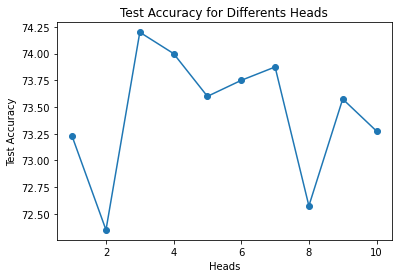

In [ ]:
plt.scatter(range(1, 11), [t*100 for t in test_accs])
plt.plot(range(1, 11), [t*100 for t in test_accs])

plt.title("Test Accuracy for Differents Heads")
plt.xlabel("Heads")
plt.ylabel("Test Accuracy")
plt.show()

In [ ]:
test_acc_sum = 0
for _ in range(NUMBER_RUNS):
  model = GATDynamicWeights(500, 32, 3, heads=3)
  train(model)
  test_acc_sum += test(model)
test_acc = test_acc_sum / NUMBER_RUNS
print(f"test accuracy = {test_acc}")

test accuracy = 0.745


In [ ]:
test_acc_sum = 0
for _ in range(NUMBER_RUNS):
  model = GAT(500, [64, 16], 3, heads=3)
  train(model)
  test_acc_sum += test(model)
test_acc = test_acc_sum / NUMBER_RUNS
print(f"test accuracy = {test_acc}")

test accuracy = 0.74075


## GAT v2

In [ ]:
def torch_sum(a, b): return a+b

In [ ]:
NUMBER_RUNS = 4
for message_operation in [torch_sum, torch.minimum, torch.maximum, torch.mul]:
  print(f"message_operation = {message_operation}", end=" ")
  test_acc_sum = 0
  for _ in range(NUMBER_RUNS):
    model = GATv2MessageOperation(in_channels=500, hidden_channels=32,
                                  out_channels=3, heads=3,
                                  message_operation=message_operation)
    train(model)
    test_acc_sum += test(model)
  
  test_acc = test_acc_sum / NUMBER_RUNS
  print(f"test accuracy = {round(test_acc*100, 2)}")

message_operation = <function torch_sum at 0x7f13a81ce670> test accuracy = 75.22
message_operation = <built-in method minimum of type object at 0x7f1417a5f420> test accuracy = 74.55
message_operation = <built-in method maximum of type object at 0x7f1417a5f420> test accuracy = 74.7
message_operation = <built-in method mul of type object at 0x7f1417a5f420> test accuracy = 74.35
